In [143]:
library(magrittr)
library(caret)
library(zeallot)
library(Matching)
library(tidyverse)
source("R/simulation_scenarios.R")
source("R/hte_caret.R")
source("R/hte_cv.R")
plotsize = function (x,y) options(repr.plot.width=x, repr.plot.height=y)

In [3]:
# returns the index of the observation most similar to the observation in that position:
# i.e. (1->5), (2->3), ... 
find_matches = function(x, w) {
    index = 1:length(w)
    treated_match = Match(Tr=w, X=x, replace=T, estimand="ATT") 
    control_match = Match(Tr=!w, X=x, replace=T, estimand="ATT")
    subject = index[c(treated_match$index.treated, control_match$index.treated)] # all subjects
    match = index[c(treated_match$index.control, control_match$index.control)] # their matches
 
    match_sorted = rep(NA,length(index))
    match_sorted[subject] = match
    return(match_sorted)
}

In [4]:
make_matrix = function(x) stats::model.matrix(~.-1, x)
covariates = function(data) data %>% dplyr::select(starts_with("covariate")) %>% make_matrix()
treatment = function(data) data$treatment
outcome = function(data) data$outcome
decompose_df = function(data) list(covariates(data), treatment(data), outcome(data))
subset_rows = function(items, index) {
    items %>% map(function(item) {
        if (is.vector(item)) item[index]
        else if (is.array(item)) item[index,]
        else stop("Don't know what to do with item of this type")
    })
}

iptw = function(p,w) 1/(1-w + 2*w*p - p)

In [6]:
model_specs = list(
gbm = list(
    tune_grid = expand.grid(
        n.trees = seq(1,501,40), 
        interaction.depth=3, 
        shrinkage = 0.1, 
        n.minobsinnode=3),
    extra_args = list(
        verbose=F, 
        bag.fraction=0.5)),
glmnet = list(
    tune_grid = expand.grid(
       alpha=c(0,0.5,1),
       lambda=exp(seq(-5,2,0.4))),
    extra_args = list()))

In [7]:
DGP = powers_DGPs()[[11]]

In [8]:
c(n_train, n_val, n_test) %<-% list(1000, 1000, 1000)
create_data(DGP, n_train + n_val + n_test) %->%
    c(data, aux_data)
itrain = 1:n_train
ival = itrain + n_train
itest = ival + n_val

In [9]:
c(x,w,y) %<-% decompose_df(data)

estimate many treatment effects models on the training set and get validation + test set estimates from each (TRAINING -> VALIDATION+TEST)

In [10]:
estimates = list(
        S=S_learners_pred_test, 
        T=T_learners_pred_test, 
        R=R_learners_pred_test) %>%
    imap(function(learner, learner_type){
        learner(itrain, x, w, y, model_specs) %>% # uses train to predict on val/test
        mutate(model = str_c(learner_type, model, sep="$"))
    }) %>% bind_rows

Warning message:
: package ‘bindrcpp’ was built under R version 3.2.5

cross-estimate mean outcome and propensity score using cross-validated models on the validation set and match on validation set (VALIDATION)

In [44]:
    list(x,w,y) %>% 
    subset_rows(ival) %->%
c(x_val, w_val, y_val)
mu_hat_val = cross_validated_cross_estimation(x_val, y_val, model_specs)
p_hat_val = cross_validated_cross_estimation(x_val, w_val, model_specs)
c(mu0_hat_val, mu1_hat_val) %<-% S_learner_cv_ce(x_val, w_val, y_val, model_specs)
matches = find_matches(x_val, w_val)

use those auxiliary data (mean_outcome, pscore, match) and (est_outcome, est_effect) on the validation set to estimate all validation metrics (VALIDATION)

In [144]:
metrics = list(
    mse = bundle_mse,
    wmse = bundle_wmse,
    r_objective = bundle_r_objective,
    match_mse = bundle_match_mse,
    trans_mse = bundle_trans_mse,
    match_mdc = bundle_match_mdc,
    trans_mdc = bundle_trans_mdc,
    ip_value = bundle_ip_value,
    dml_value = bundle_dml_value,
    gain = bundle_gain,
#     c_benefit = bundle_c_benefit,
    qini = bundle_qini,
#     ip_value_auc = bundle_ip_value_auc,
    random = bundle_random)
val_bundle = list(
    matches = find_matches(x_val, w_val),
    w = w_val,
    y = y_val,
    mu0 = mu0_hat_val,
    mu1 = mu1_hat_val,
    pseudo_outcome = (y_val - mu_hat_val)/(w_val - p_hat_val),
    weight = (w_val - p_hat_val)^2,
    iptw = iptw(p_hat_val, w_val)
    )

In [145]:
val_estimates_grp = estimates %>% 
    filter(index<=max(ival)) %>%
    group_by(model)
val_metrics = metrics %>% imap(function(metric, metric_name) {
    val_estimates_grp %>% 
        summarize(!!metric_name:=metric(val_bundle, y_hat, tau_hat))
}) %>% reduce(inner_join, by="model")

apply tMSE and value to test-set estimates from all models using (true_effect) and (est_effect) (TEST)

In [146]:
aux_data[itest,] %$% 
list(true_effect, treated_mean, control_mean) %->%
c(tau_test, mu1_test, mu0_test)

true_test_metrics = estimates %>% 
    filter(min(itest)<=index) %>%
    group_by(model) %>%
    summarize(
        tmse = mse(tau_test, tau_hat),
        value = mean(mu1_test*(tau_hat>0) + mu0_test*(tau_hat<=0)))

Warning message:
: Removed 8 rows containing missing values (geom_point).

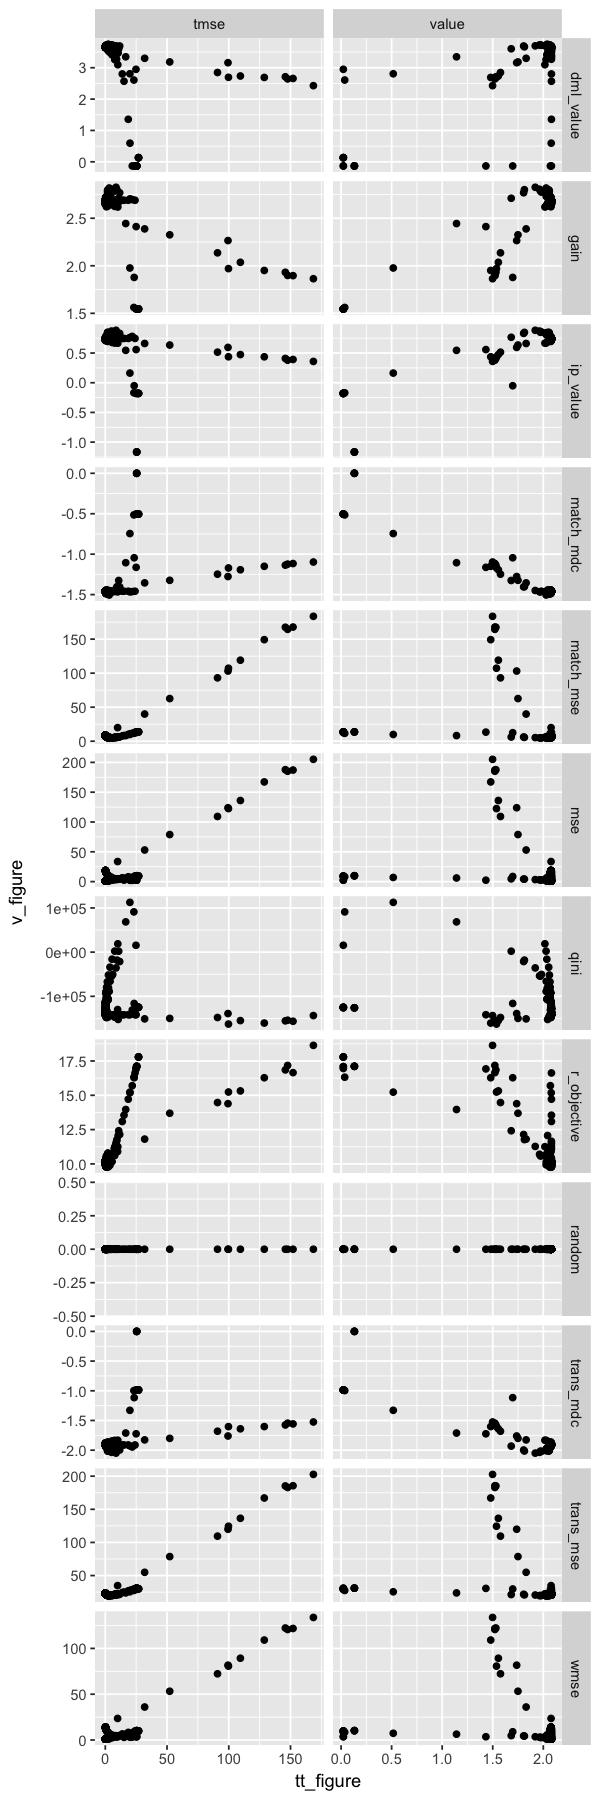

In [147]:
plotsize(5,15)

ttm = true_test_metrics %>% gather(tt_metric, tt_figure, -model)
vm = val_metrics %>% gather(v_metric, v_figure, -model)

inner_join(ttm, vm, by="model") %>%
ggplot(aes(x=tt_figure, y=v_figure)) +
geom_point() +
facet_grid(v_metric~tt_metric, scales="free")

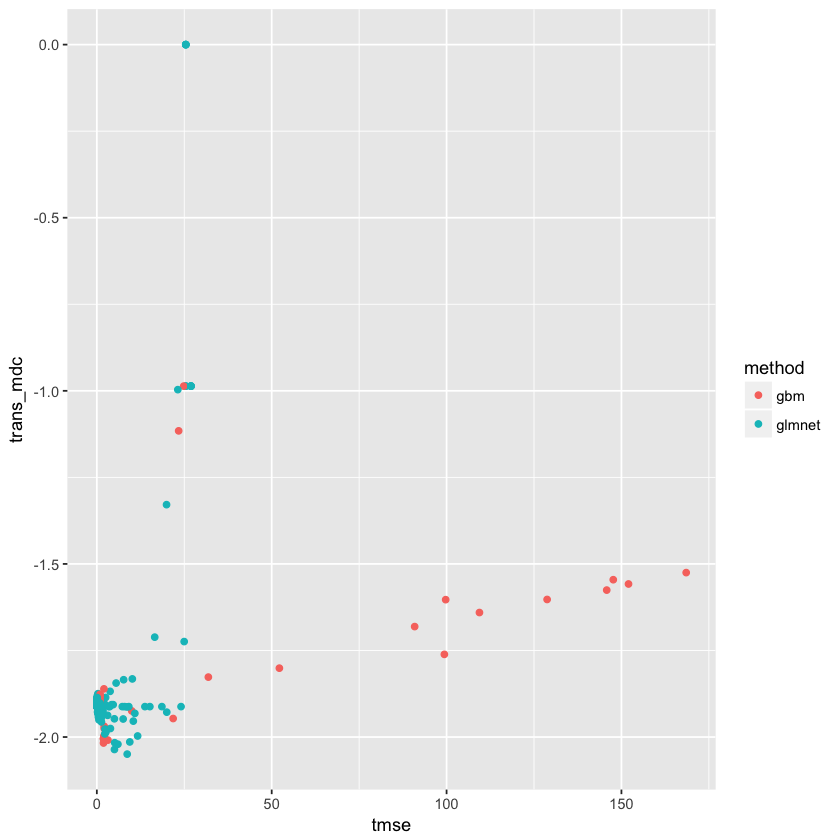

In [136]:
inner_join(true_test_metrics, val_metrics, by="model")%>%
separate(model, c("learner", "model"), sep="\\$") %>%
separate(model, c("method", "params"), sep="@") %$%
qplot(tmse, trans_mdc, color=method)